# Problem 2

In [2]:
import json
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pprint import pprint
import numpy as np
import os
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.utils.extmath import randomized_svd
from sklearn import metrics
from string import punctuation
from nltk import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import re

In [3]:
def in_washington(location):
    white_list = ["seattle","washington","wa","kirkland"]
    black_list = ["dc","d.c.","d.c."]

    flag = False

    location = location.split()
    for s in white_list:
        if s in location:
            flag = True
            break
    for s in black_list:
        if s in location:
            flag = False
            break
    return flag

def in_mas(location):
    white_list = ["ma","massachusetts","boston","worcester","salem","plymouth","springfield","arlington","scituate","northampton"]
    black_list = ["ohio",]

    flag = False
    
    location = location.split()
    for s in white_list:
        if s in location:
            flag = True
            break
    for s in black_list:
        if s in location:
            flag = False
            break
    return flag

In [4]:
stop_words_skt = text.ENGLISH_STOP_WORDS
stemmer = SnowballStemmer('english')
combined_stopwords = set.union(set(stop_words_skt),set(punctuation))

def preprocess(doc):
    analyzer = CountVectorizer().build_analyzer()
    doc=re.sub(r'[^A-Za-z]', " ", doc)
    return (stemmer.stem(w) for w in analyzer(doc) if w not in combined_stopwords)


In [26]:
# =========================== Pre-processing the tweets into content list and labels ===================================

tweet_content = []
tweet_labels = []

input_file = open('tweet_data/tweets_#superbowl.txt',encoding='utf-8')
for (line, index) in zip(input_file, range(0, 1348767)):
    data = json.loads(line)
    location=data.get('tweet').get('user').get('location')
    if in_washington(location):
        tweet_content.append(data.get("title"))
        tweet_labels.append(0)
    elif in_mas(location):
        tweet_content.append(data.get("title"))
        tweet_labels.append(1)


In [27]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('CountVectorizer', CountVectorizer(min_df=5,analyzer=preprocess,stop_words=combined_stopwords)),
                      ('tf-idf', TfidfTransformer()),('svd', TruncatedSVD(n_components=50))])

X = pipeline.fit_transform(tweet_content)
Y = np.array(tweet_labels)

print(X.shape)
print(Y.shape)

(1351, 50)
(1351,)


In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_curve, auc

def print_statistics(actual, predicted):
    accuracy = accuracy_score(actual, predicted)
    recall = recall_score(actual, predicted)
    precision = precision_score(actual, predicted)
    print ('accuracy score is:', accuracy)
    print ('recall score is:', recall)
    print ('precision score is:', precision)
    
    #print("Confusion Matrix is ", smet.confusion_matrix(actual, predicted))
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.4f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkgreen',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


def classify(X, Y, classifier, cname):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
    #b = 0.85 * X.shape[0]
    #X_train = X[:b, :]
    #Y_train = Y[:b]
    #X_test = X[b:, :]
    #Y_test = Y[b:]

    classifier.fit(X_train, Y_train)
    predicted = classifier.predict(X_test)
    predicted_probs = classifier.predict_proba(X_test)

    print_statistics(Y_test, predicted)
    cnf_matrix = confusion_matrix(Y_test, predicted)
    plot_confusion_matrix(cnf_matrix, ['WA','MA'])
    
    fpr = dict()
    tpr = dict()
    fpr, tpr, thresholds = roc_curve(Y_test, predicted)
    plot_roc(fpr, tpr)

Statistics of SVM classifier:
accuracy score is: 0.7573529411764706
recall score is: 0.9130434782608695
precision score is: 0.5915492957746479
Confusion matrix, without normalization
[[61 29]
 [ 4 42]]


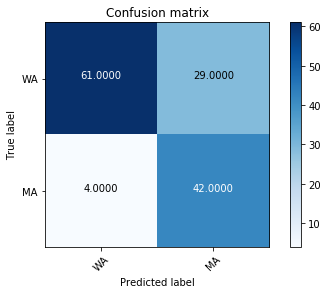

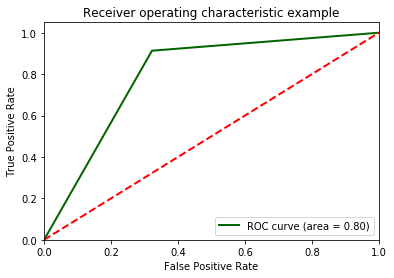

Statistics of LogisticRegression:
accuracy score is: 0.7647058823529411
recall score is: 0.782608695652174
precision score is: 0.6206896551724138
Confusion matrix, without normalization
[[68 22]
 [10 36]]


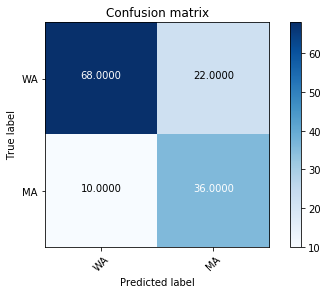

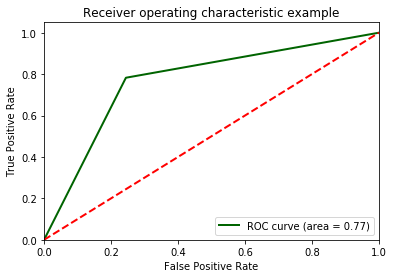

Statistics of Naive Bayes Classifier:
accuracy score is: 0.7573529411764706
recall score is: 0.8913043478260869
precision score is: 0.5942028985507246
Confusion matrix, without normalization
[[62 28]
 [ 5 41]]


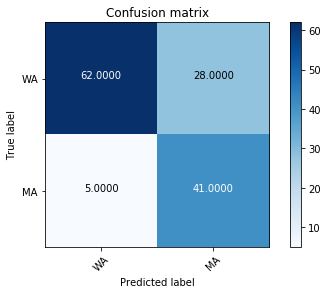

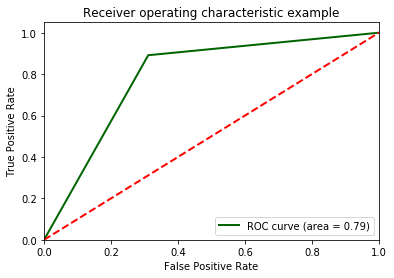

In [25]:
print("Statistics of SVM classifier:")
classify(X, Y, svm.SVC(kernel='linear', probability=True), "SVM")

print("Statistics of LogisticRegression:")
classify(X, Y, LogisticRegression(), "LogisticRegression")

print("Statistics of Naive Bayes Classifier:")
classify(X, Y, BernoulliNB(), "BernoulliNB")